# Analyze the relationship between Cvalue (genome size) and variables such as nutrition

- 01: Data cleaning
- 02a: ML exploration for Cvalue predictors
- 02b: ML exploration for No_bugs predictors
- 04: build a new phylogeny
- **03a: PGLS phylogenetic controlled comparison for CVal**
- 03b: PGLS phylogenetic controlled comparison for No_bugs

The data for Cvalue and other ecological features were taken from the EcoFlora database circa 2011 using a database dump provided by the developer and a series of SQL queries.

The original tree however had very few members that overlapped with our data from EcoFlora. I found a more recent phylogeny and pruned that using the `R` package `U.PhyloMaker` in the file `03_newTree.rmd`.

Step 1: load libraries and data. 

In [1]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import numpy as np
# Load your data
data = pd.read_csv('./data/cleaned_20240729')

indepVar = ['leafP_val', 'leafN_val', 'clonality_state', 'dicliny_val', 'soil_nutr_val', 'log_long_val']
data['log_long_val'] = np.log(data['long_val'])

In [2]:
data

,plant_no,long_val,soil_nutr_val,leafP_val,leafN_val,clonality_state,dicliny_val,plant_name,genus,family,Cval,No_bugs,log_long_val
0,260070070,100.0,0.0,1.0,10.0,1,3.0,PINUS SYLVESTRIS,PINUS,PINACEAE,NaN,65.0,4.605170
1,280050020,100.0,0.0,1.0,10.0,1,1.0,JUNIPERUS COMMUNIS,JUNIPERUS,CUPRESSACEAE,NaN,16.0,4.605170
2,290010010,500.0,3.0,1.0,10.0,1,1.0,TAXUS BACCATA,TAXUS,TAXACEAE,NaN,25.0,6.214608
3,310010590,NaN,1.0,NaN,NaN,1,1.0,SALIX LAPPONUM,SALIX,SALICACEAE,NaN,3.0,NaN
4,310020020,NaN,NaN,NaN,NaN,0,1.0,POPULUS X CANESCENS,POPULUS,SALICACEAE,NaN,9.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1731,2030240140,NaN,NaN,NaN,NaN,1,4.0,ORCHIS PURPUREA,ORCHIS,ORCHIDACEAE,NaN,NaN,NaN
1732,2030240180,NaN,NaN,NaN,NaN,1,4.0,ORCHIS MASCULA,ORCHIS,ORCHIDACEAE,NaN,NaN,NaN
1733,2030300010,NaN,NaN,NaN,NaN,1,4.0,OPHRYS INSECTIFERA,OPHRYS,ORCHIDACEAE,NaN,NaN,NaN
1734,2030300160,NaN,NaN,NaN,NaN,1,4.0,OPHRYS FUCIFLORA,OPHRYS,ORCHIDACEAE,NaN,NaN,NaN


In [3]:
# Assuming the list corresponds to the index of the DataFrame
# Create a boolean mask where the it is not NaN for Cval
mask = ~pd.isna(data['Cval'])

# Apply the mask to the DataFrame to keep corresponding rows
data = data[mask]

# Display the filtered DataFrame and list
data


,plant_no,long_val,soil_nutr_val,leafP_val,leafN_val,clonality_state,dicliny_val,plant_name,genus,family,Cval,No_bugs,log_long_val
7,340020020,100.0,2.0,1.0,20.0,1,3.0,ALNUS GLUTINOSA,ALNUS,BETULACEAE,1.10,47.0,4.605170
8,340020020,100.0,2.0,1.0,20.0,1,1.0,ALNUS GLUTINOSA,ALNUS,BETULACEAE,1.10,47.0,4.605170
11,360010010,100.0,2.0,2.0,20.0,1,3.0,FAGUS SYLVATICA,FAGUS,FAGACEAE,0.80,23.0,4.605170
15,400010020,0.5,2.0,3.0,30.0,2,1.0,URTICA DIOICA,URTICA,URTICACEAE,2.90,28.0,-0.693147
24,470040010,0.5,2.0,3.0,20.0,2,1.0,FALLOPIA JAPONICA,FALLOPIA,POLYGONACEAE,6.48,9.0,-0.693147
...,...,...,...,...,...,...,...,...,...,...,...,...,...
574,1931110010,0.5,1.0,NaN,NaN,1,4.0,DANTHONIA DECUMBENS,DANTHONIA,POACEAE,5.90,NaN,-0.693147
575,1931130010,0.5,0.0,1.0,10.0,1,4.0,MOLINIA CAERULEA,MOLINIA,POACEAE,4.60,6.0,-0.693147
576,1931160010,2.0,1.0,1.0,10.0,1,4.0,NARDUS STRICTA,NARDUS,POACEAE,4.20,4.0,0.693147
587,1970010010,1.0,3.0,NaN,NaN,2,3.0,SPARGANIUM ERECTUM,SPARGANIUM,SPARGANIACEAE,1.10,2.0,0.000000


### Step 2: Impute missing data and standardize data

In [4]:
indepVar


['leafP_val',
 'leafN_val',
 'clonality_state',
 'dicliny_val',
 'soil_nutr_val',
 'log_long_val']

In [6]:
from sklearn.impute import KNNImputer
# Standardize the data
scaler = KNNImputer(n_neighbors=3)

data[indepVar] = scaler.fit_transform(data.loc[:, indepVar])

# Impute missing values
imputer = SimpleImputer(strategy='mean')
data[indepVar] = imputer.fit_transform(data.loc[:,indepVar])

data

<ipython-input-6-235ad8181d14>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[indepVar] = scaler.fit_transform(data.loc[:, indepVar])
c:\Users\Seth\Anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
<ipython-input-6-235ad8181d14>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

,plant_no,long_val,soil_nutr_val,leafP_val,leafN_val,clonality_state,dicliny_val,plant_name,genus,family,Cval,No_bugs,log_long_val
7,340020020,100.0,2.0,1.000000,20.000000,1.0,3.0,ALNUS GLUTINOSA,ALNUS,BETULACEAE,1.10,47.0,4.605170
8,340020020,100.0,2.0,1.000000,20.000000,1.0,1.0,ALNUS GLUTINOSA,ALNUS,BETULACEAE,1.10,47.0,4.605170
11,360010010,100.0,2.0,2.000000,20.000000,1.0,3.0,FAGUS SYLVATICA,FAGUS,FAGACEAE,0.80,23.0,4.605170
15,400010020,0.5,2.0,3.000000,30.000000,2.0,1.0,URTICA DIOICA,URTICA,URTICACEAE,2.90,28.0,-0.693147
24,470040010,0.5,2.0,3.000000,20.000000,2.0,1.0,FALLOPIA JAPONICA,FALLOPIA,POLYGONACEAE,6.48,9.0,-0.693147
...,...,...,...,...,...,...,...,...,...,...,...,...,...
574,1931110010,0.5,1.0,0.833333,10.000000,1.0,4.0,DANTHONIA DECUMBENS,DANTHONIA,POACEAE,5.90,NaN,-0.693147
575,1931130010,0.5,0.0,1.000000,10.000000,1.0,4.0,MOLINIA CAERULEA,MOLINIA,POACEAE,4.60,6.0,-0.693147
576,1931160010,2.0,1.0,1.000000,10.000000,1.0,4.0,NARDUS STRICTA,NARDUS,POACEAE,4.20,4.0,0.693147
587,1970010010,1.0,3.0,2.000000,23.333333,2.0,3.0,SPARGANIUM ERECTUM,SPARGANIUM,SPARGANIACEAE,1.10,2.0,0.000000


### Step 3: Tidy up the names so that they match the new tree produced

In [7]:
# convert 'genus' to title case to match the tree
data['genus'] = data['genus'].str.title()
data['family'] = data['family'].str.title()
data['plant_name'] = data['plant_name'].str.title()

data['plant_name'] = data['plant_name'].str.replace(" ", "_")
data.columns
data

<ipython-input-7-f124724262db>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['genus'] = data['genus'].str.title()
<ipython-input-7-f124724262db>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['family'] = data['family'].str.title()
<ipython-input-7-f124724262db>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

,plant_no,long_val,soil_nutr_val,leafP_val,leafN_val,clonality_state,dicliny_val,plant_name,genus,family,Cval,No_bugs,log_long_val
7,340020020,100.0,2.0,1.000000,20.000000,1.0,3.0,Alnus_Glutinosa,Alnus,Betulaceae,1.10,47.0,4.605170
8,340020020,100.0,2.0,1.000000,20.000000,1.0,1.0,Alnus_Glutinosa,Alnus,Betulaceae,1.10,47.0,4.605170
11,360010010,100.0,2.0,2.000000,20.000000,1.0,3.0,Fagus_Sylvatica,Fagus,Fagaceae,0.80,23.0,4.605170
15,400010020,0.5,2.0,3.000000,30.000000,2.0,1.0,Urtica_Dioica,Urtica,Urticaceae,2.90,28.0,-0.693147
24,470040010,0.5,2.0,3.000000,20.000000,2.0,1.0,Fallopia_Japonica,Fallopia,Polygonaceae,6.48,9.0,-0.693147
...,...,...,...,...,...,...,...,...,...,...,...,...,...
574,1931110010,0.5,1.0,0.833333,10.000000,1.0,4.0,Danthonia_Decumbens,Danthonia,Poaceae,5.90,NaN,-0.693147
575,1931130010,0.5,0.0,1.000000,10.000000,1.0,4.0,Molinia_Caerulea,Molinia,Poaceae,4.60,6.0,-0.693147
576,1931160010,2.0,1.0,1.000000,10.000000,1.0,4.0,Nardus_Stricta,Nardus,Poaceae,4.20,4.0,0.693147
587,1970010010,1.0,3.0,2.000000,23.333333,2.0,3.0,Sparganium_Erectum,Sparganium,Sparganiaceae,1.10,2.0,0.000000


In [8]:
data['genus'].nunique()

96

### Load libraries for handling the tree and stats on it

In [9]:
import statsmodels.api as sm
from statsmodels.regression.mixed_linear_model import MixedLM

# Load your phylogenetic tree using Biopython
from Bio import Phylo

### Import the tree.
See the R file `newTree.rmd` for how this was produced. 

Collect the `phylo_groups` using a lambda through the `.find_clades()` function on our tree. Then map those values onto our data.


In [10]:
tree = Phylo.read(file='./data/pruned_megatree_20240730.tre', format='newick')

# Create a dictionary to map species to their phylogenetic groups
phylo_groups = {clade.name: idx for idx, clade in enumerate(tree.find_clades())}
data['phylo_group'] = data['plant_name'].map(phylo_groups)

<ipython-input-10-cef141ab6557>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['phylo_group'] = data['plant_name'].map(phylo_groups)


In [11]:
phylo_groups # some odd ones in there

{'Spermatophyta': 0,
 'mrcaott2ott2645': 1,
 'Mesangiospermae': 2,
 'mrcaott2ott121': 3,
 'mrcaott2ott10930': 4,
 'eudicotyledons': 5,
 'mrcaott2ott8379': 6,
 'Pentapetalae': 7,
 'mrcaott248ott19688': 8,
 'mrcaott248ott557': 9,
 'mrcaott248ott27233': 10,
 'mrcaott248ott650': 11,
 'mrcaott248ott320': 12,
 'campanulids': 13,
 'mrcaott320ott1673': 14,
 'mrcaott320ott77310': 15,
 'Asterales.rn.d8s.tre': 16,
 None: 2362,
 'Seriphidium_Maritimum': 19,
 'Rudbeckia_Laciniata': 20,
 'Eupatorium_Cannabinum': 28,
 'Galinsoga_Quadriradiata': 30,
 'Galinsoga_Parviflora': 31,
 'Bidens_Frondosa': 33,
 'Bidens_Cernua': 34,
 'Bidens_Tripartita': 35,
 'Bidens_Connata': 36,
 'Filago_Pyramidata': 40,
 'Filago_Lutescens': 41,
 'Filago_Vulgaris': 42,
 'Filago_Minima': 43,
 'Antennaria_Dioica': 44,
 'Gnaphalium_Supinum': 46,
 'Gnaphalium_Norvegicum': 47,
 'Gnaphalium_Uliginosum': 48,
 'Gnaphalium_Sylvaticum': 49,
 'Gnaphalium_Luteoalbum': 50,
 'Pulicaria_Dysenterica': 53,
 'Pulicaria_Vulgaris': 54,
 'Inula_C

In [12]:
data
# Find duplicates in the 'text' column
duplicates = data[data.duplicated('plant_name')]

# Print the duplicates
print(duplicates)


       plant_no  long_val  soil_nutr_val  leafP_val  leafN_val  \
8     340020020     100.0            2.0   1.000000  20.000000   
44    570060070       NaN            2.0   1.166667  16.666667   
105   680080010       NaN            0.0   0.833333  13.333333   
114   680410200       0.5            2.0   0.666667  13.333333   
122   680680010       0.5            2.0   1.333333  16.666667   
123   680680010       0.5            2.0   0.666667  13.333333   
248  1290250160       0.5            1.0   1.000000  10.000000   
249  1290250160       0.5            1.0   1.000000  10.000000   
272  1291080080       0.5            1.0   0.833333  10.000000   
273  1291080080       0.5            1.0   0.833333  10.000000   
397  1630010200       0.5            2.0   0.500000  10.000000   
416  1670080380       0.5            1.0   0.833333  10.000000   
417  1670080380       0.5            1.0   1.000000  10.000000   

     clonality_state  dicliny_val               plant_name        genus  \


In [13]:
# Filter out all duplicates based on 'plant_name'
df_no_duplicates = data.drop_duplicates(subset='plant_name', keep='first')

# Print the resulting DataFrame
print(df_no_duplicates)

       plant_no  long_val  soil_nutr_val  leafP_val  leafN_val  \
7     340020020     100.0            2.0   1.000000  20.000000   
11    360010010     100.0            2.0   2.000000  20.000000   
15    400010020       0.5            2.0   3.000000  30.000000   
24    470040010       0.5            2.0   3.000000  20.000000   
30    480020010       NaN            2.0   0.833333  16.666667   
..          ...       ...            ...        ...        ...   
574  1931110010       0.5            1.0   0.833333  10.000000   
575  1931130010       0.5            0.0   1.000000  10.000000   
576  1931160010       2.0            1.0   1.000000  10.000000   
587  1970010010       1.0            3.0   2.000000  23.333333   
589  1990010010       NaN            1.0   0.833333  10.000000   

     clonality_state  dicliny_val           plant_name       genus  \
7                1.0          3.0      Alnus_Glutinosa       Alnus   
11               1.0          3.0      Fagus_Sylvatica       Fagus 

### Confirm that there aren't any rows without phylo_group assigned

In [14]:
mask = ~pd.isna(df_no_duplicates['phylo_group'])

# Apply the mask to the DataFrame to keep corresponding rows
data_thin = df_no_duplicates[mask]
data_thin

data_thin.shape
# v few in the tree 96

(96, 14)

### Remove any extreme outliers (one case with very high Cval)

In [15]:
# Calculate Z-scores for the target variable
from scipy.stats import zscore
data_thin['Cval_zscore'] = zscore(data_thin['Cval'])

# Identify outliers (e.g., Z-score > 3 or < -3)
outliers = data_thin[np.abs(data_thin['Cval_zscore']) > 3]
outliers

,plant_no,long_val,soil_nutr_val,leafP_val,leafN_val,clonality_state,dicliny_val,plant_name,genus,family,Cval,No_bugs,log_long_val,phylo_group,Cval_zscore
506,1830230010,0.5,2.0,0.666667,13.333333,1.0,4.0,Fritillaria_Meleagris,Fritillaria,Liliaceae,141.4,NaN,-0.693147,2239,7.936262


### Fritillaria_Meleagris has Cvalue of 141, which is intense.

In [16]:

# drop those
# Remove outliers from the DataFrame
data_thin = data_thin[np.abs(data_thin['Cval_zscore']) <= 3]

# Drop the Z-score column as it's no longer needed
data_thin = data_thin.drop(columns=['Cval_zscore'])


### Separate out the variables and add a constant for the model

In [17]:
# Define the independent variables
X = data_thin[indepVar]
Y = data_thin['Cval']
# Add a constant to the model (intercept)
X = sm.add_constant(X)

### Run the Mixed Linear Model for Phylogenetic Generalized Least Squares

In [18]:
# 
# Using 'phylo_group' as a random effect to account for phylogenetic relatedness

# For number of insects
md = MixedLM(Y, X, groups=data_thin['phylo_group'])
pgls = md.fit()
print(pgls.summary())

           Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  Cval     
No. Observations:   95       Method:              REML     
No. Groups:         95       Scale:               45.9730  
Min. group size:    1        Log-Likelihood:      -338.6647
Max. group size:    1        Converged:           Yes      
Mean group size:    1.0                                    
-----------------------------------------------------------
                Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
-----------------------------------------------------------
const           -3.616    6.428 -0.563 0.574 -16.214  8.983
leafP_val        1.655    1.874  0.883 0.377  -2.018  5.328
leafN_val       -0.070    0.210 -0.332 0.740  -0.481  0.342
clonality_state -0.274    3.704 -0.074 0.941  -7.533  6.986
dicliny_val      2.106    1.299  1.621 0.105  -0.440  4.653
soil_nutr_val    2.506    1.178  2.127 0.033   0.197  4.814
log_long_val    -0.946    0.935 -1.012 0.312  -2.77

c:\Users\Seth\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


### Summary
With the larger tree we do see a (modest) relationship between soil nutritional value and Cvalue size Coef:1.981

Reservations:
1. have there been any errors in production of the spreadsheet from plant.db? How can I check that?

------



## Try with standardized Cval?

I looked into it a bit and it seems that scaling is helpful for some ML approaches but not regressions (looses interpretability). Trying below, just for the sake of it. 

In [19]:
# Standardize the data
y = np.array(Y)
y = y.reshape(-1, 1)
Yscaled = scaler.fit_transform(y)

In [20]:
# Using 'phylo_group' as a random effect to account for phylogenetic relatedness

# For number of insects
md = MixedLM(Yscaled, X, groups=data_thin['phylo_group'])
pgls = md.fit()
print(pgls.summary())

           Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  y        
No. Observations:   95       Method:              REML     
No. Groups:         95       Scale:               45.9730  
Min. group size:    1        Log-Likelihood:      -338.6647
Max. group size:    1        Converged:           Yes      
Mean group size:    1.0                                    
-----------------------------------------------------------
                Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
-----------------------------------------------------------
const           -3.616    6.428 -0.563 0.574 -16.214  8.983
leafP_val        1.655    1.874  0.883 0.377  -2.018  5.328
leafN_val       -0.070    0.210 -0.332 0.740  -0.481  0.342
clonality_state -0.274    3.704 -0.074 0.941  -7.533  6.986
dicliny_val      2.106    1.299  1.621 0.105  -0.440  4.653
soil_nutr_val    2.506    1.178  2.127 0.033   0.197  4.814
log_long_val    -0.946    0.935 -1.012 0.312  -2.77

c:\Users\Seth\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


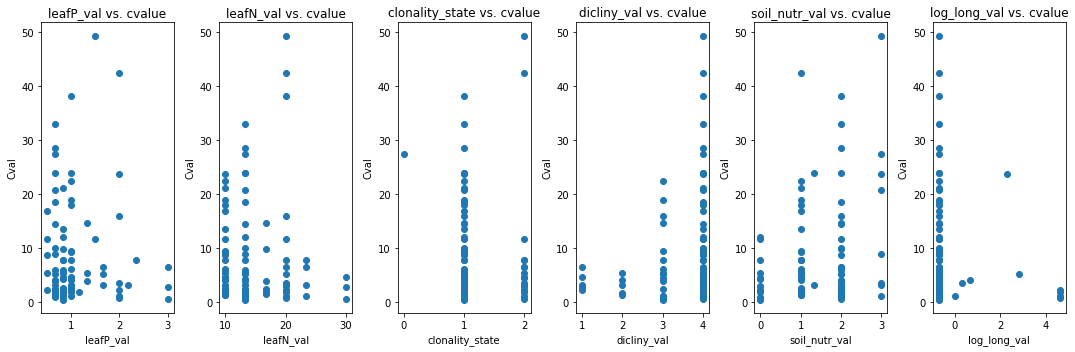

In [21]:
import matplotlib.pyplot as plt
# summarize with histograms

# Create scatter plots
plt.figure(figsize=(15, 5))
for i, var in enumerate(indepVar, 1):
    plt.subplot(1, len(indepVar), i)
    plt.scatter(data_thin[var], data_thin['Cval'])
    plt.xlabel(var)
    plt.ylabel('Cval')
    plt.title(f'{var} vs. cvalue')

plt.tight_layout()
plt.show()
